In [2]:
import qcodes as qc
from qdev_wrappers.fitting.least_squares_models import DecayingRabis, DecayT1
from qdev_wrappers.fitting.fitter import Fitter
from qdev_wrappers.fitting.plot_analysis_by_id import plot_analysis_by_id
from qcodes.dataset.plotting import plot_by_id

/anaconda3/envs/qcodes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import numpy as np
from qcodes.dataset.data_export import get_data_by_id
from qcodes.dataset.measurements import Measurement

## Initialize fitter

The Fitter takes a model, and optionally also a guess and an r2 limit for rejecting "fits" that fit the data very poorly. By default, the guess will be the found using the guess function of the model, and the r2 limit will be None.

The model includes information about the paramters to be fitted, their labels and units, a default initial guess for the parameters, and the specifics about the type of fit that the model uses. Information specific to the method of fitting is handeled by the model, not the fitter. 

### Perform fit and see result

We will use the model *DecayingRabis()* from the 'least squares' fitting models. Least squares fitting uses the scipy curve_fit function, and returns, in addition to fitted parameter values, a variance matrix.

In [4]:
model = DecayingRabis()

We can check the parameters and the function that will be used for fitting:

In [5]:
model.parameters

{'a': {'label': '$a$', 'unit': ''},
 'T': {'label': '$T$', 'unit': 's'},
 'w': {'label': '$\\omega$', 'unit': 'Hz'},
 'p': {'label': '$\\phi$', 'unit': ''},
 'c': {'label': '$c$', 'unit': ''}}

In [6]:
model.func_np 

'a*np.exp(-x/T)*np.sin(w*x+p)+c'

We initialize the fitter using the default guess method, and give it an r2_limit of 0.5 to reject especially poor fits (see other example notebook for examples with and without r2 limits):

In [7]:
fitter = Fitter(model, r2_limit=0.5)

## Fitting while measuring

Since we aren't fitting from saved data, we will not use *fitter.fit_by_id*. Instead, we will use *fitter.fit*, which takes numpy arrays, and fits to them. The first argument is the outputted array. Other arguments must be keyword arguments, telling the fitter which function variable to assign the data array to. For example, it would accept:

fitter.fit( np.array( [ 1, 2, 3, 4 ] ) ,  x=np.array( [ 1, 2, 3, 4 ] ) )

This can then be incorportated into a measurement, to fit the data during the measurement:

In [18]:
# data I will be using
frequency = get_data_by_id(6)[0][0]
pulse_duration = get_data_by_id(6)[0][1]
cavity_response = get_data_by_id(6)[0][2]

### Setup

Setup of the measurement is as normal. The process similar for setting up the fit 'measurement'. The setpoints that the parameters depend on (in this case, frequency) and fit parameters need to be registered to the fit 'measurement'.

In [28]:
# create a measurement for the normal measurement, and register measurement parameters
meas = Measurement()

meas.register_custom_parameter(name='frequency', label='Frequency', unit='Hz')
meas.register_custom_parameter(name='pulse_duration', label='Pulse Duration', unit='s')
meas.register_custom_parameter(name='cavity_response', label='Cavity Response', unit='V', 
                               setpoints=('pulse_duration', 'frequency'))

# create measurement to store the fit, and register setpoints and fit parameters
analysis = Measurement()
analysis.name = 'analysis'

analysis.register_custom_parameter(name='frequency', label='Frequency', unit='Hz')

for param_name, param_info in model.parameters.items():
    analysis.register_custom_parameter(name=param_name, label=param_info['label'], unit=param_info['unit'], 
                                      setpoints=('frequency', ))

The measurement then proceeds as normal. The fit 'measurement' is nested inside the normal measurement. In order to identify what is being fitted, and how, later, some metadata needs to be added to the datasaver for the fit measurement.

After recording each sweep on the measurement, the arrays that were saved for that sweep are passed to fitter.fit, returning paramter values and a param_dict. 

The param_dict contains additional information about the fit that we aren't worrying about now - for example, the variance of each parameter. You could choose to register other things (f.x. variance) as parameters and save them as well. In this instance, we are doing the simplest possible thing and just saving the parameter values - we aren't saving any information about initial guesses or variance.

*param_values* will be **None** if the fit was rejected (by the r2 test), and nothing will be saved at that frequency. Otherwise, the parameter results at the frequency are saved. Then it goes on to the next frequency.

In [29]:
with meas.run() as datasaver:
    run_id = datasaver.run_id
    
    with analysis.run() as fitsaver:     
        analysis_id = fitsaver.run_id
        
        # add metadata to fit, for identifying model and dataset for fit later
        inferred_from = {'run_id': run_id, 'dept_var': 'cavity_response'}
        metadata = model.summary
        if fitter.r2_limit is not None:
            metadata['r2_limit'] = fitter.r2_limit
        fitsaver.dataset.add_metadata('inferred_from', inferred_from)
        fitsaver.dataset.add_metadata('model', metadata)
        
        # measurement as normal, plus fitting
        freqs = np.unique(frequency['data'])

        for freq in freqs:
            # get data from the 1d sweep at freq
            indices = [np.argwhere(frequency['data'] == freq).flatten()]
            pulse_dur = pulse_duration['data'][indices]
            cav_response = cavity_response['data'][indices]
            # save sweep result
            datasaver.add_result(('frequency', freq),
                                 ('pulse_duration', pulse_dur),
                                 ('cavity_response', cav_response))
            
            # fit to the 1d sweep
            param_values, param_dict = fitter.fit(cav_response, x=pulse_dur)
            #save fit result if successful fit was found
            if param_values is not None:
                sweep_result = [('frequency', freq)]
                for param_name in model.parameters.keys(): 
                    sweep_result.append((param_name, param_values[param_name]))
                fitsaver.add_result(*sweep_result)


Starting experimental run with id: 230
Starting experimental run with id: 231
inserting {'inferred_from': {'run_id': 230, 'dept_var': 'cavity_response'}}
inserting {'model': {'method': 'Least squares', 'function': {'func_str': '$f(x) = a \\exp(-x/T) \\sin(\\omega x +\\phi) + c$', 'func_np': 'a*np.exp(-x/T)*np.sin(w*x+p)+c'}, 'parameters': {'a': {'label': '$a$', 'unit': ''}, 'T': {'label': '$T$', 'unit': 's'}, 'w': {'label': '$\\omega$', 'unit': 'Hz'}, 'p': {'label': '$\\phi$', 'unit': ''}, 'c': {'label': '$c$', 'unit': ''}}, 'r2_limit': 0.5}}


/Users/Lillian/qdev-wrappers/qdev_wrappers/fitting/fitter.py:127: UserWarning: Unsuccessful fit - r2 for fit is below limit 0.5
  warnings.warn(f'Unsuccessful fit - r2 for fit is below limit {self.r2_limit}')


## Comparison to taking a full dataset, then measuring

Fitting after each sweep and saving the measurement and fit simultaneously gives you the same result for both the measurement and the fit as taking the full dataset and then fitting afterwards.

The original, full dataset is run 6. For comparison, the dataset saved while fitting after each 1D sweep (run 231):

([<matplotlib.axes._subplots.AxesSubplot at 0x11c8977b8>],
 [<matplotlib.colorbar.Colorbar at 0x11c60f358>])

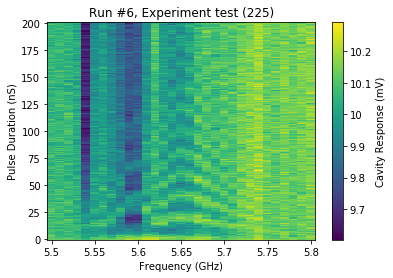

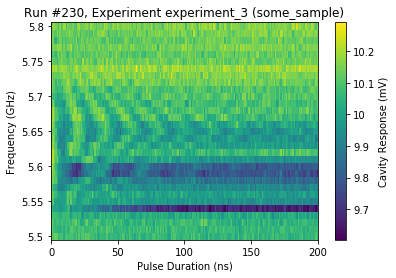

In [35]:
#full dataset
plot_by_id(6)
#data saved while fitting
plot_by_id(230)

We can also compare the results of the fit taken and saved in between sweeps with the results of a fit for the completed dataset:

In [40]:
fit = fitter.fit_by_id(6, 'data', x='pulse_duration')

/Users/Lillian/qdev-wrappers/qdev_wrappers/fitting/fitter.py:127: UserWarning: Unsuccessful fit - r2 for fit is below limit 0.5
  warnings.warn(f'Unsuccessful fit - r2 for fit is below limit {self.r2_limit}')


inserting {'model': {'method': 'Least squares', 'function': {'func_str': '$f(x) = a \\exp(-x/T) \\sin(\\omega x +\\phi) + c$', 'func_np': 'a*np.exp(-x/T)*np.sin(w*x+p)+c'}, 'parameters': {'a': {'label': '$a$', 'unit': ''}, 'T': {'label': '$T$', 'unit': 's'}, 'w': {'label': '$\\omega$', 'unit': 'Hz'}, 'p': {'label': '$\\phi$', 'unit': ''}, 'c': {'label': '$c$', 'unit': ''}}, 'r2_limit': 0.5}, 'inferred_from': {'run_id': 6, 'exp_id': 1, 'dept_var': 'data'}}

 Analysis saved with run id 232


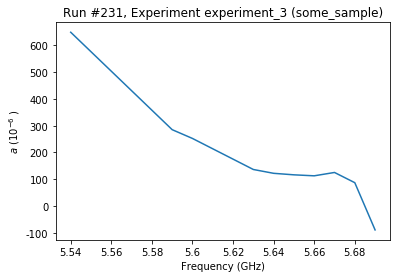

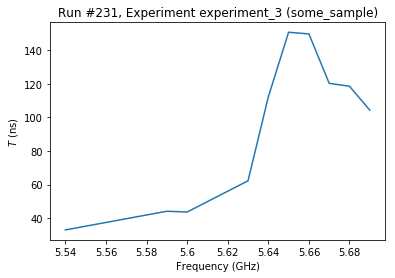

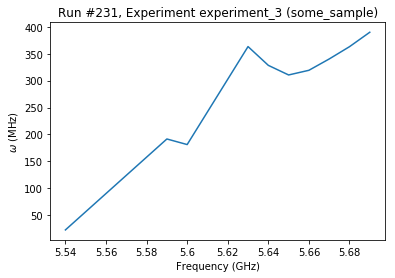

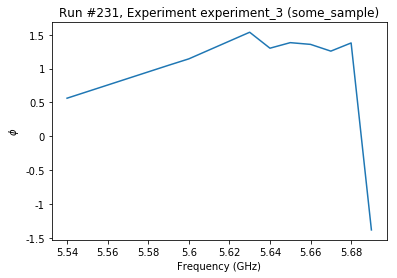

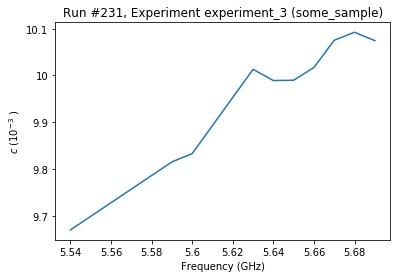

In [43]:
# fitted 'while measuring'
plot_analysis_by_id(231)

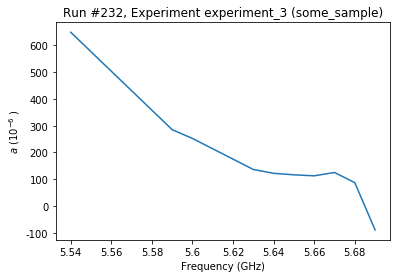

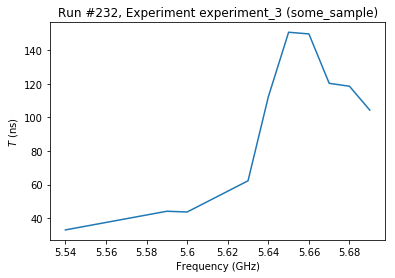

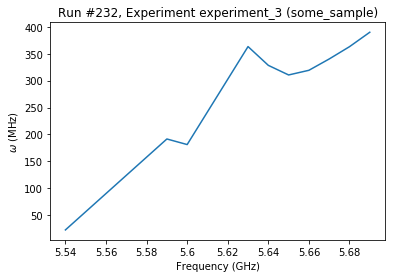

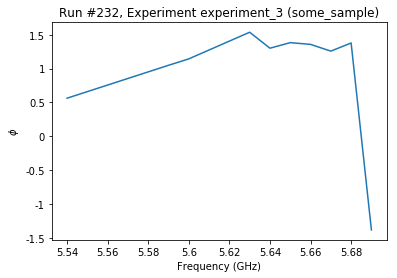

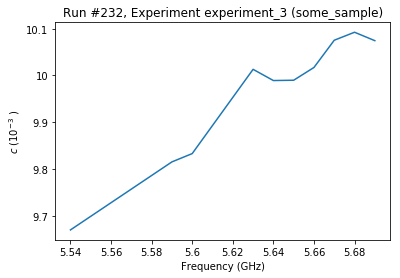

In [44]:
# fitted to completed dataset
plot_analysis_by_id(232)

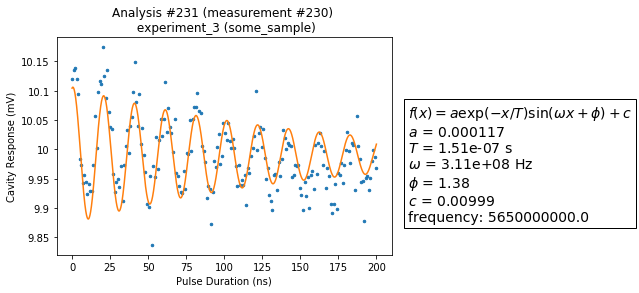

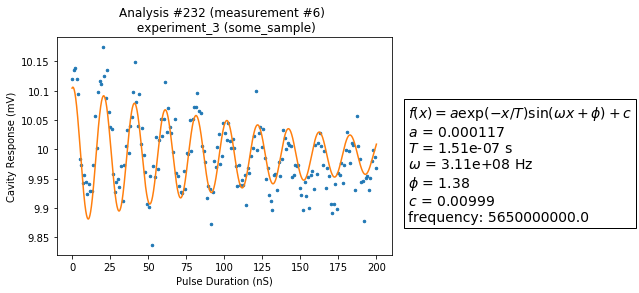

In [46]:
# fitted 'while measuring'
plot_analysis_by_id(231, frequency=5.65e9)
# fitted to completed dataset
plot_analysis_by_id(232, frequency=5.65e9)